### Here's the link to the [dataset](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction/download) used in this Notebook

In [0]:
#!pip install -U pandas-profiling

In [104]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [105]:
pip install eli5

In [106]:
pip install PDPbox

In [107]:
!pip install chart_studio

In [108]:
pip install shap

In [109]:
# Upload the file
from google.colab import files
files.upload()

Saving fake_job_postings.csv to fake_job_postings (2).csv


In [130]:
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.read_csv('fake_job_postings.csv')

# Look through the report on the dataset
df.profile_report(pool_size=1,minimal=True).to_notebook_iframe() 

In [132]:
# That's a baseline for "not fraud"
df['fraudulent'].value_counts(normalize=True).max()

0.9515659955257271

### Feature eng

In [0]:
# Divide the 'location' column into three columns:'country,' 'state,' 'city'
df['country'] = df['location'].str.split(",").str[0]
df['state'] = df['location'].str.split(",").str[1]
df['city'] = df['location'].str.split(",").str[2]
df = df.drop(['location'], axis = 1)

In [136]:
# Check for NaN values in the dataset
df.isna().sum() 

job_id                     0
title                      0
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
country                  346
state                    440
city                     440
dtype: int64

In [138]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split df into train & test
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                               random_state=42)
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                               random_state=42)

train.shape, val.shape, test.shape

((11443, 20), (2861, 20), (3576, 20))

In [140]:
# Check for NaN values in the 'fraudulent' column
train['fraudulent'].isna().sum()

0

In [142]:
# See the class destribution in the 'fraudulent' column
train['fraudulent'].value_counts()

0    10910
1      533
Name: fraudulent, dtype: int64

In [0]:
# Assign target and features
target = 'fraudulent'
columns_drop = ['job_id'] # Drop 'job_id' because of it high cardinality
features = train.columns.drop([target] + columns_drop)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [191]:
# Let's fit our first model, Decision Tree Classifier
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(criterion = 'entropy', max_depth = 20,random_state=42))

pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.8580915763718979


#### Get Feature Importances

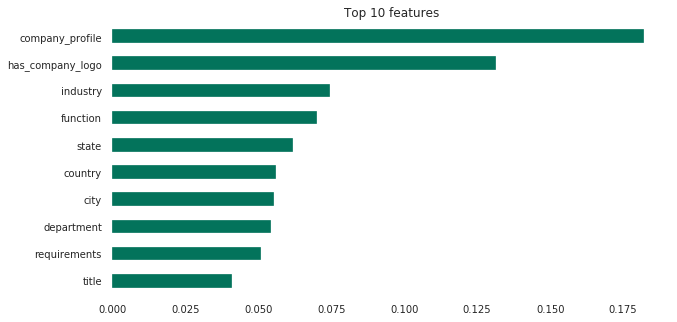

In [192]:
# Get feature importances
dtc = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(dtc.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='#03735b');

#### ROC AUC validation score

In [150]:
train['fraudulent'].value_counts(normalize=True).max()

0.9534213056016779

In [152]:
# Find the ROC AUC score
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict(X_val)
roc_auc_score(y_val, y_pred_proba)

0.7201409531580891

In [154]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) at various threshold settings.

# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2
1,0.125508,0.565789,1
2,1.000000,1.000000,0


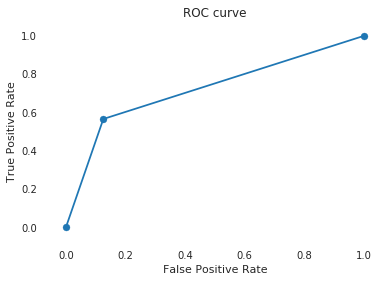

In [156]:
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

##  Visualizations

#### Confusion Matrix

In [158]:
from sklearn.metrics import accuracy_score
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.9468717231737155


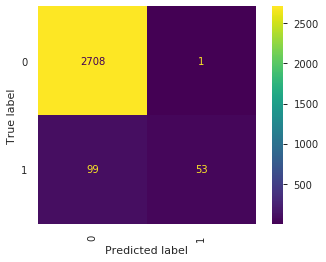

In [160]:
# Plot the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [162]:
# Plot the Classification Report for Decision Tree Classifier
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2709
           1       0.00      0.00      0.00       152

    accuracy                           0.95      2861
   macro avg       0.47      0.50      0.49      2861
weighted avg       0.90      0.95      0.92      2861



#### Permutation Importances


In [164]:
# fit Random Forest Classifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [166]:
from eli5.sklearn.permutation_importance import PermutationImportance
permuter = PermutationImportance(
    model, 
    scoring='explained_variance', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [168]:
import eli5

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

# Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.2687 ± 0.0404,company_profile
0.2649 ± 0.0431,has_company_logo
0.1643 ± 0.0575,country
0.1642 ± 0.0365,industry
0.1073 ± 0.0092,function
0.0921 ± 0.0103,has_questions
0.0749 ± 0.0454,city
0.0634 ± 0.0110,employment_type
0.0616 ± 0.0347,required_education
0.0585 ± 0.0312,state


#### Partial Dependence Plot, 1 feature isolation

In [170]:
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 -5.23938237065532


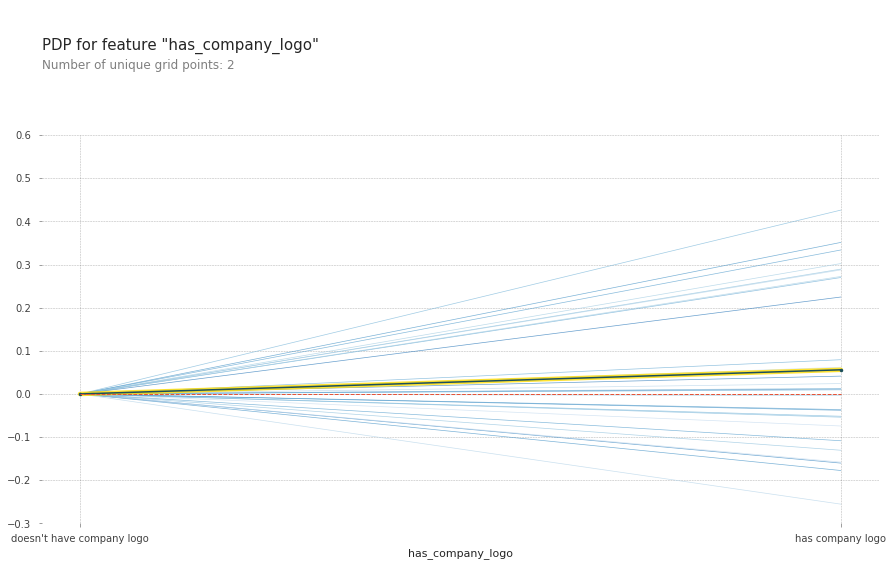

In [171]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'has_company_logo'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)
plt.xticks([0, 1], ["doesn't have company logo", 'has company logo'])
plt.ylim(-0.3,0.6);

#### Partial Dependence Plot, 2 features interaction

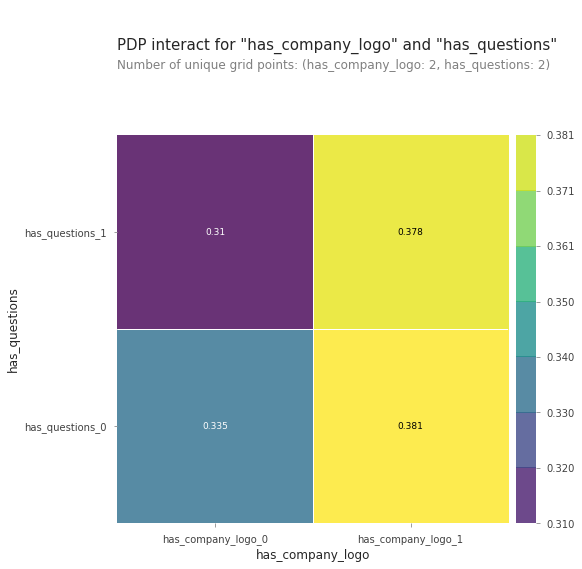

In [172]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['has_company_logo', 'has_questions']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

#### 3D with Plotly

In [0]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

In [174]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)))

fig = go.Figure(surface, layout)
fig.show()

In [0]:
import chart_studio
username = 'tt.sova' # your username
api_key = 'E5CgRRUA1F0OiUcWIImy' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [176]:
import chart_studio.plotly as py
py.plot(fig, filename = 'partial_dependence', auto_open=True)

'https://plot.ly/~tt.sova/3/'

#### Shapley Value Plot

In [177]:
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.841635	validation_1-auc:0.603574
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.86921	validation_1-auc:0.60592
[2]	validation_0-auc:0.869184	validation_1-auc:0.605512
[3]	validation_0-auc:0.862983	validation_1-auc:0.607624
[4]	validation_0-auc:0.884946	validation_1-auc:0.65227
[5]	validation_0-auc:0.884446	validation_1-auc:0.651826
[6]	validation_0-auc:0.884244	validation_1-auc:0.652139
[7]	validation_0-auc:0.886477	validation_1-auc:0.68056
[8]	validation_0-auc:0.887878	validation_1-auc:0.684015
[9]	validation_0-auc:0.886607	validation_1-auc:0.684527
[10]	validation_0-auc:0.888196	validation_1-auc:0.668973
[11]	validation_0-auc:0.892708	validation_1-auc:0.673632
[12]	validation_0-auc:0.892721	validation_1-auc:0.674266
[13]	validation_0-auc:0.895211	validation_1-auc:0.676705
[14]	validation_0-auc:0.896015	validation_1-auc:0.689002
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [178]:
row = X_test.iloc[[-16]]
row

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,country,state,city
14598,Digital Sales Manager,Sales,NaN,"Propoint provides custom, visual solutions tha...",Propoint is an award-winning creative studio i...,WHAT IT TAKES.You need to be a sales person at...,PAY &amp; PERKS.Competitive base and uncapped ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Graphic Design,Sales,US,NY,New York


In [179]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

In [180]:
row = X_test.iloc[[7]]
row

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,country,state,city
4989,English Teacher Abroad (Conversational),NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it.Vacancies in A...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,Education,US,MN,Duluth


In [181]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

#### Let's try some other models that better suit an imbalanced dataset 

In [182]:
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LogisticRegression(random_state=42,solver='newton-cg'))

pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.9468717231737155


In [183]:
y_pred = pipeline.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2861
           1       0.00      0.00      0.00         0

    accuracy                           0.95      2861
   macro avg       0.50      0.47      0.49      2861
weighted avg       1.00      0.95      0.97      2861



In [184]:
# random forest is another model which perfectly suits imbalanced dataset
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(criterion = 'entropy', max_depth = 20,random_state=42))

pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.9650471862984971


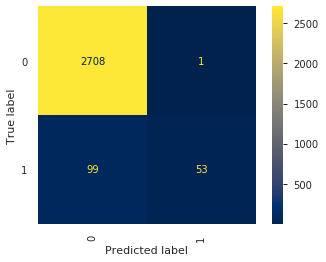

In [185]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(pipeline,
                      X_val, y_val,
                      values_format='.0f',
                      xticks_rotation='vertical',
                      cmap='cividis');

In [186]:
y_pred = pipeline.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2807
           1       0.35      0.98      0.51        54

    accuracy                           0.97      2861
   macro avg       0.67      0.97      0.75      2861
weighted avg       0.99      0.97      0.97      2861



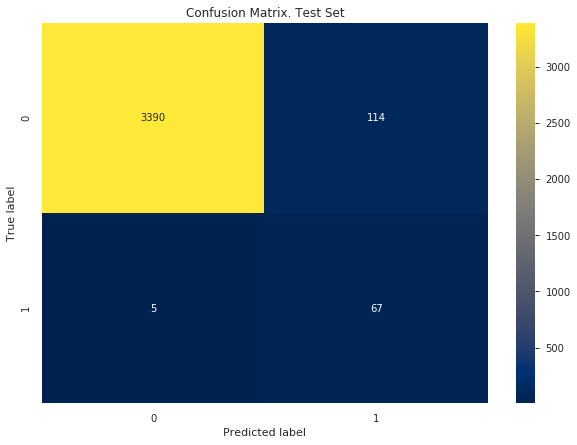

In [187]:
import seaborn as sns
y_pred = pipeline.predict(X_test)
conf_mat = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, cmap='cividis', annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix. Test Set");

In [188]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3504
           1       0.37      0.93      0.53        72

    accuracy                           0.97      3576
   macro avg       0.68      0.95      0.76      3576
weighted avg       0.99      0.97      0.97      3576



In [189]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_pred, y_test)
print('Precision:', precision)
print("Recall:", recall)

Precision: [0.02013423 0.37016575 1.        ]
Recall: [1.         0.93055556 0.        ]
